In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 100,
})

import numpy as np

rng = np.random.default_rng()

# Build an arena

Position inside arena will be discretized according to a hexagonal grid.

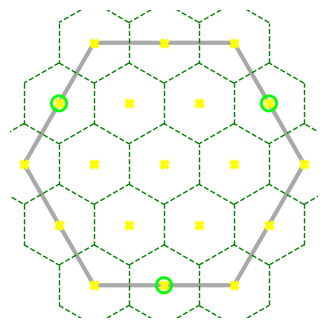

In [2]:
from hexarena.arena import Arena

arena = Arena(2)
fig, ax = plt.subplots(figsize=(4, 4))
arena.plot_mesh(ax)
fig.savefig('arena-map.png', bbox_inches='tight')

# Build a food box

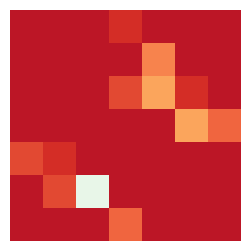

In [3]:
from hexarena.box import StationaryBox

box = StationaryBox(num_grades=20, num_patches=49, sigma=0.2)
box.reset()

fig, ax = plt.subplots(figsize=(3, 3))
h = ax.imshow(box.colors, vmin=-1, vmax=box.num_grades, cmap='RdYlBu_r')
ax.set_axis_off()

def init():
    box.reset()
    h.set_data(box.colors)
    return h,

def update(i):
    box.step(0)
    h.set_data(box.colors)
    return h,

num_frames = 80
ani = FuncAnimation(fig, update, frames=range(num_frames), init_func=init, blit=True)
ani.save('color-cues.gif')

# Build a foraging environment

In [4]:
from hexarena.env import ForagingEnv

box = {'_target_': 'hexarena.box.RestorableBox', 'num_grades': 20, 'num_patches': 49, 'sigma': 0.01}
env = ForagingEnv(
    arena={'resol': 2},
    boxes=[dict(theta_tau=tau, **box) for tau in [3, 4.2, 7]],
    monkey={'move_price': 0.},
)

## Run an example trial with random policy

In [5]:
from irc.buffer import Episode

states, observations, actions, rewards, infos = [], [], [], [], []
num_steps = 120

observation, info = env.reset()
states.append(env.get_state())
observations.append(observation)
infos.append(info)
for _ in range(num_steps):
    action = env.action_space.sample()
    observation, reward, _, _, info = env.step(action)
    actions.append(action)
    rewards.append(reward)
    states.append(env.get_state())
    observations.append(observation)
    infos.append(info)

episode = Episode(
    num_steps, True,
    np.array(states), np.array(observations), np.array(actions), np.array(rewards),
    infos=infos,
)

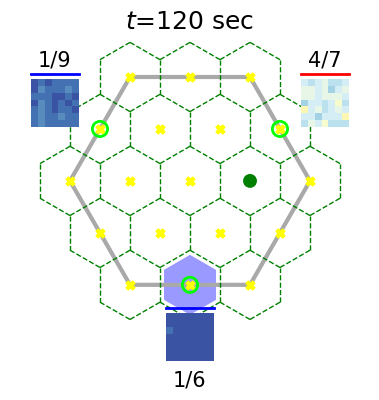

In [6]:
pos, gaze, rewarded, foods, colors, counts, _ = env.convert_episode(episode)

fig, ani = env.play_episode(pos, gaze, rewarded, foods, colors, counts)
ani.save('example-trial.gif', fps=6)